In [1]:
from src.data.paths import project_dir
from src.data.analysis import Circle, create_circular_mask
from src.data.detector import find_circle_hough_method, img_for_circle_detection
from src.data.detector import find_circle_hough_method, img_for_circle_detection, DetectorDataCollection, DetectorData, DetectorImage

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from scipy.ndimage import center_of_mass

from dataclasses import dataclass, field
from pathlib import Path

import tifffile 

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import seaborn as sns
from scipy.ndimage import center_of_mass
import pandas as pd

from pathlib import Path
import random
import math
from copy import deepcopy
import shutil
from collections import defaultdict
from tqdm.notebook import tqdm

from src.visualise.plot import plot_data, plot_data_simple
from src.data.paths import project_dir
from src.data.analysis import Circle, create_circular_mask, read_tiff_img
from src.data.detector import find_circle_hough_method, img_for_circle_detection, DetectorDataCollection, DetectorData, DetectorImage

# Data structures

In [2]:
@dataclass(frozen=True)
class TupleXY:
    x: float
    y: float

@dataclass(frozen=True)
class CuttingParameters:
    foil_init_center: TupleXY
    foil_init_size: TupleXY = field(default=TupleXY(120, 120))
    cut_px: int = 100
    r_envelope_start: int = 150
    max_radius: int = 70
    min_radius: int = 30

# EBT3 Calibration

In [3]:
@dataclass
class Calibration:
    a0 : float = 0
    a1 : float = 0
    a2 : float = 0
    a3 : float = 0

    def __call__(self, x):
        return self.a0 + self.a1*x + self.a2*x**2 + self.a3*x**3

    def __repr__(self):
        result = f'f(x) = '
        first_item = True
        if self.a0 != 0:
            result += f'{self.a0}'
            if first_item:
                first_item = False
            else:
                result += ' +'
        if self.a1 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a1}*x'
        if self.a2 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a2}*x^2'
        if self.a3 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a3}*x^3'
        return result

ebt3_proton_calib_20Gy = Calibration(a1=9.62189, a3=78.75125)
ebt3_proton_calib_20Gy

f(x) =  9.62189*x + 78.75125*x^3

In [4]:
netOD_test = 0.28
ebt3_proton_calib_20Gy(netOD_test)

4.422876640000001

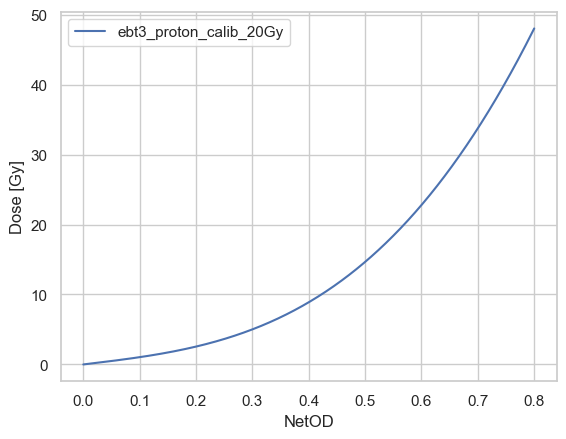

In [5]:
netOD_plot = np.linspace(0, 0.8, 800)

fig, ax = plt.subplots()
ax.plot(netOD_plot, ebt3_proton_calib_20Gy(netOD_plot), label='ebt3_proton_calib_20Gy')
ax.set_xlabel('NetOD')
ax.set_ylabel('Dose [Gy]')
ax.legend()

# EBT3 20 Gy entrance data loading

In [6]:
base_path = Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils'
base_path.exists()

True

In [7]:
image_path = base_path / "2024-12-12/20Gy_wlot/img026.tif"
image_path.exists()

True

In [8]:
def net_optical_density(image: np.ndarray, channel_no : int = 0) -> np.ndarray:
    bg_r = 42804.451 
    bg_g = 44273.485
    bg_b = 27929.477 
    bg = [bg_r, bg_g, bg_b]
    return np.log10(bg[channel_no] / image[:, :, channel_no])

In [9]:
def ebt3_dose_Gy(image: np.ndarray, calib: Calibration = ebt3_proton_calib_20Gy, channel_no : int = 0) -> np.ndarray:
    return calib(net_optical_density(image, channel_no))

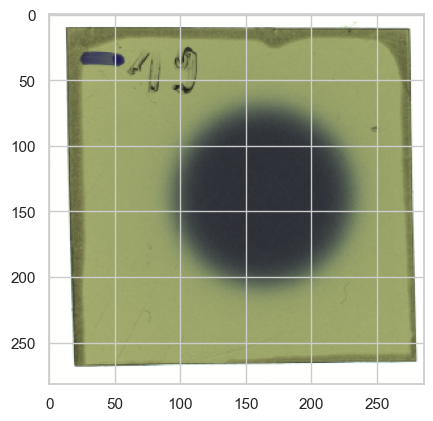

In [10]:
im = tifffile.imread(image_path)
im.shape, im.dtype
plt.imshow(im / im.max(), cmap='gray')

In [11]:
net_optical_density(im).min(), net_optical_density(im).max()

(-0.1849843725036639, 0.760909470708901)

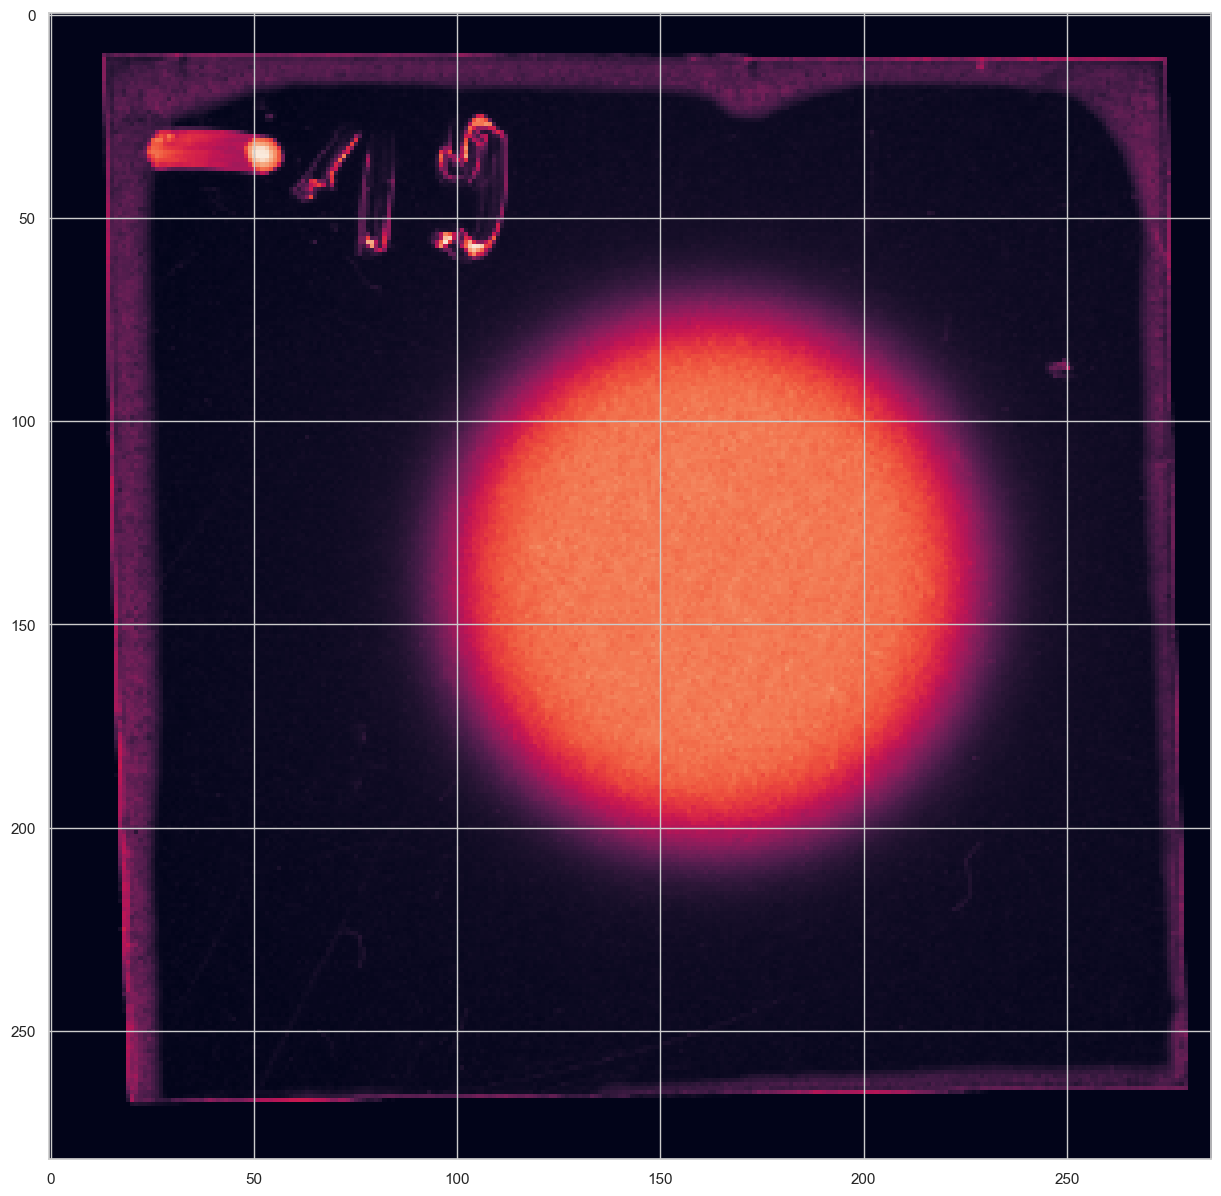

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np.where(net_optical_density(im) < 0, 0, net_optical_density(im)))
#plt.colorbar()

## Single foil tests

### Foil selection

In [13]:
foil_init_center = (150, 150)
foil_init_dx = 120
foil_init_dy = 120
foil_cut1 = im[foil_init_center[0]-foil_init_dx:foil_init_center[0]+foil_init_dx,
             foil_init_center[1]-foil_init_dy:foil_init_center[1]+foil_init_dy]

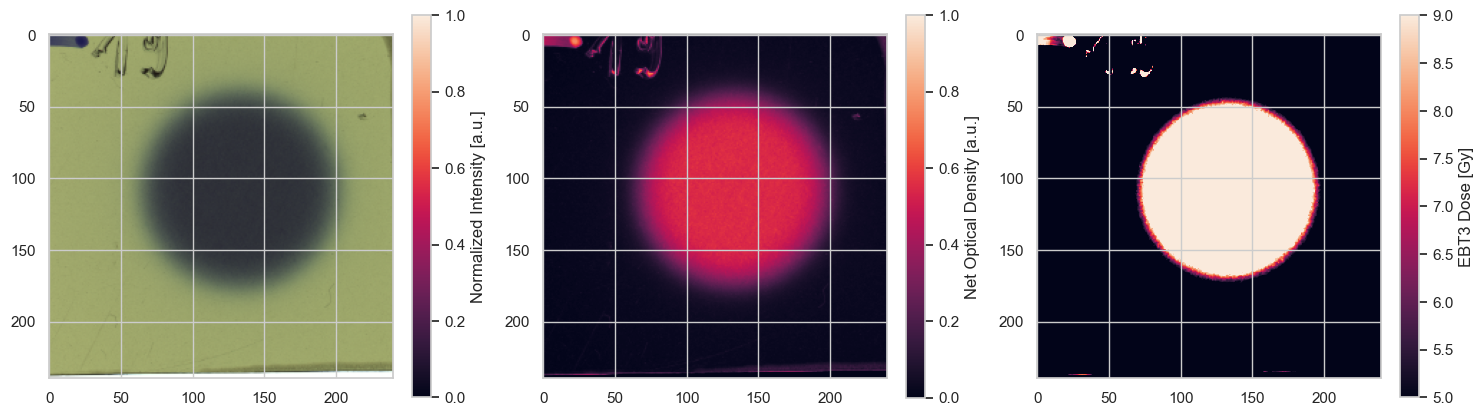

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), facecolor='none')
im1 = axs[0].imshow(foil_cut1 / foil_cut1.max(), vmin=0, vmax=1.0)
im2 = axs[1].imshow(net_optical_density(foil_cut1), vmin=0, vmax=1.0)
im3 = axs[2].imshow(ebt3_dose_Gy(foil_cut1), vmin=5, vmax=9)

fig.colorbar(im1, label='Normalized Intensity [a.u.]', fraction=0.05)
fig.colorbar(im2, label='Net Optical Density [a.u.]', fraction=0.05)
fig.colorbar(im3, label='EBT3 Dose [Gy]', fraction=0.05)

plt.tight_layout()

#fig.savefig(base_path / '2024-05-28_PB_silicon_20Gy' / 'data'  / 'interim' / 'PB_20Gy' / 'ebt3_method.svg')

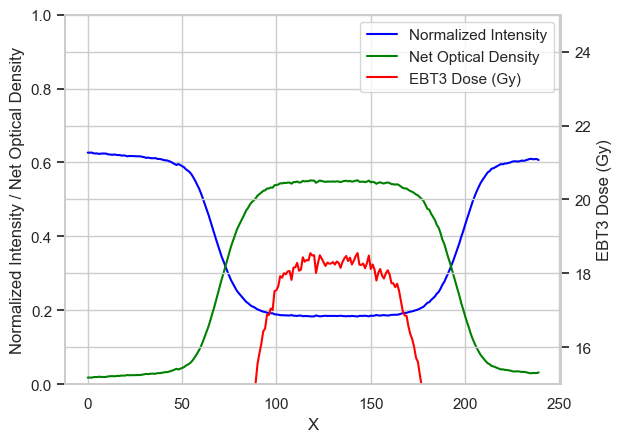

In [15]:
fig, ax = plt.subplots()
x_slice = slice(100,150)
ax.plot((foil_cut1 / foil_cut1.max())[x_slice, :, 0].mean(axis=0), label='Normalized Intensity', color='blue')
ax.plot(net_optical_density(foil_cut1)[x_slice, :].mean(axis=0), label='Net Optical Density', color='green')
ax_twin = ax.twinx()
ax_twin.plot(ebt3_dose_Gy(foil_cut1)[x_slice, :].mean(axis=0), label='EBT3 Dose (Gy)', color='red')
ax.set_xlabel('X')
ax.set_ylabel('Normalized Intensity / Net Optical Density')
ax_twin.set_ylabel('EBT3 Dose (Gy)')
ax.set_ylim(0, 1)
ax_twin.set_ylim(15, 25)
# legend for ax and ax_twin
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
ax_twin.legend(lines + lines2, labels + labels2, loc=0)


### Detector cutting

In [16]:
dpi = 300
ebt_px_to_mm = 25.4 / dpi
ebt_px_to_mm

0.08466666666666667

r_envelope = 76.95, vmax = 21.72


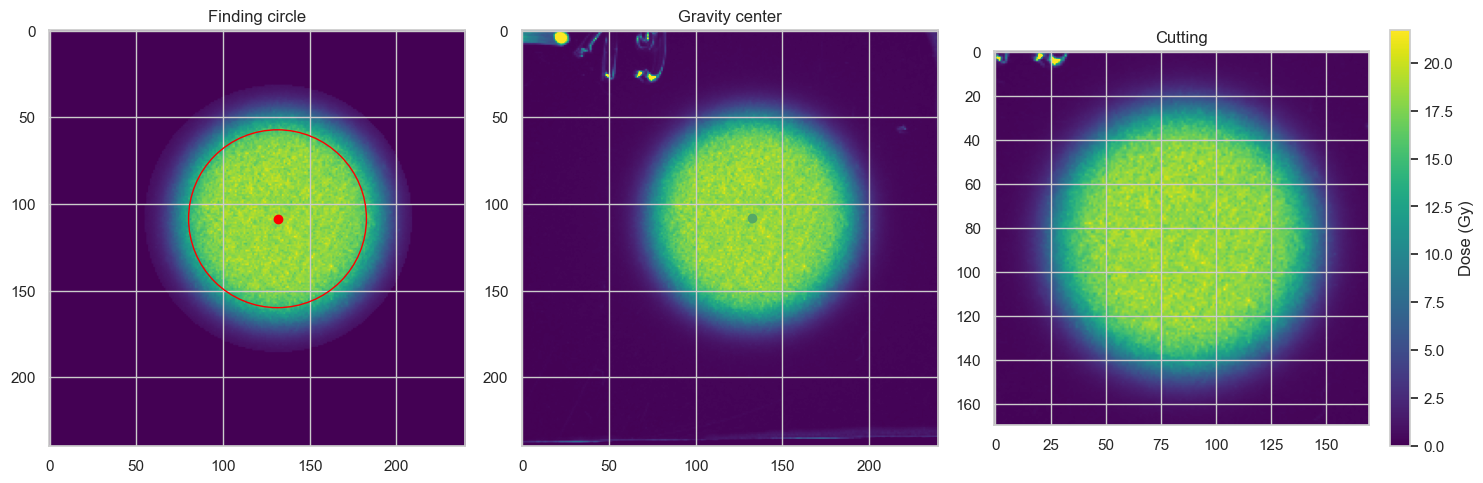

In [17]:
data = ebt3_dose_Gy(foil_cut1)[:,:]

# finding circle
data_for_circle = data.copy()
lv_for_detect = img_for_circle_detection(data_for_circle, nsigma=1)
circle = find_circle_hough_method(lv_for_detect, max_radius=280, min_radius=50)
vmin =  0
r_envelope = min(1.5*circle.r, 150)
mask = create_circular_mask(data_for_circle, Circle(x=circle.x, y=circle.y, r=r_envelope))
vmax = 1.1*np.percentile(data_for_circle[mask], 99)
data_for_circle[~mask] = 0
print(f"r_envelope = {r_envelope:.2f}, vmax = {vmax:.2f}")

# finding center of mass
data_for_cm = data_for_circle.copy()
cm = center_of_mass(data_for_cm)

# detector cutting
cut_px = 85
low_y = int(max(0, cm[0] - cut_px))
high_y = int(min(data.shape[0], cm[0] + cut_px))
low_x = int(max(0, cm[1] - cut_px))
high_x = int(min(data.shape[1], cm[1] + cut_px))
data_cut = data[low_y:high_y, low_x:high_x]

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

im1 = axs[0].imshow(data_for_circle, cmap='viridis', vmin=0, vmax=vmax)
axs[0].plot(circle.x, circle.y, 'o', color='red')
axs[0].add_artist(
    plt.Circle(xy=(circle.x, circle.y),
               radius=circle.r,
               color='red',
               fill=False,
               transform=axs[0].transData))
axs[0].set_title('Finding circle')

im2 = axs[1].imshow(data, cmap='viridis', vmin=0, vmax=vmax)
axs[1].scatter(cm[1], cm[0], color='g');
axs[1].set_title('Gravity center')

im3 = axs[2].imshow(data_cut, cmap='viridis', vmin=0, vmax=vmax)
axs[2].set_title('Cutting')

fig.colorbar(im3, label='Dose (Gy)', fraction=0.05)

plt.tight_layout()

In [18]:
data_cut.shape

(170, 170)

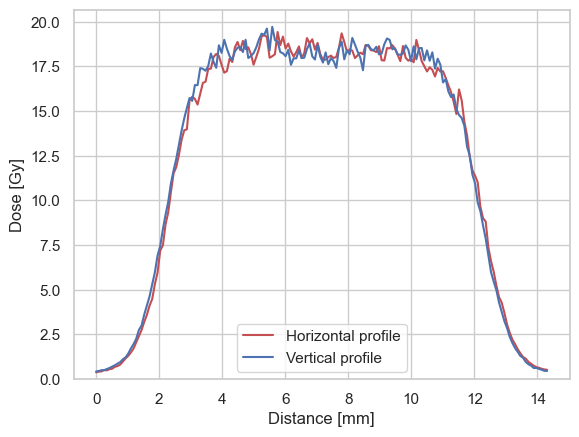

In [19]:
# plot horizontal and vertical profiles
profile_dx = 5
# plot as function of distance in mm, assuming 300dpi
res = 300
y_data = np.mean(data_cut[data_cut.shape[0]//2 - profile_dx//2:data_cut.shape[0]//2 + profile_dx//2,:], axis=0)
y_data_2 = np.mean(data_cut[:, data_cut.shape[1]//2 - profile_dx//2:data_cut.shape[1]//2 + profile_dx//2], axis=1)
x_mm = np.arange(y_data.shape[0]) / res * 25.4
plt.plot(x_mm, y_data , color='r', label='Horizontal profile')
plt.plot(x_mm, y_data_2, color='b', label='Vertical profile')
plt.ylim(0, None)
plt.xlabel('Distance [mm]')
plt.ylabel('Dose [Gy]')
plt.legend();

In [20]:
def radial_profile(data_cut: np.ndarray, px_to_mm: float, precision: int = 2) -> pd.DataFrame:
    r = []
    v = []
    cm = (data_cut.shape[0]//2, data_cut.shape[1]//2)
    for i in range(data_cut.shape[0]):
        for j in range(data_cut.shape[1]):
            v_to_cm = ((i - cm[0])**2 + (j - cm[1])**2)**0.5
            r.append(v_to_cm)
            v.append(data_cut[i, j])
    df_r = pd.DataFrame({'r': r, 'v': v})
    df_r['r_mm'] = df_r['r'] * px_to_mm 
    df_r['r_mm_round'] = df_r['r_mm'].round(precision)
    #df_r['v_norm'] = df_r['v'] / df_r['v'][df_r['r_mm'] < 3].mean()
    df_r
    return df_r

18.36088304246658
18.36088304246658


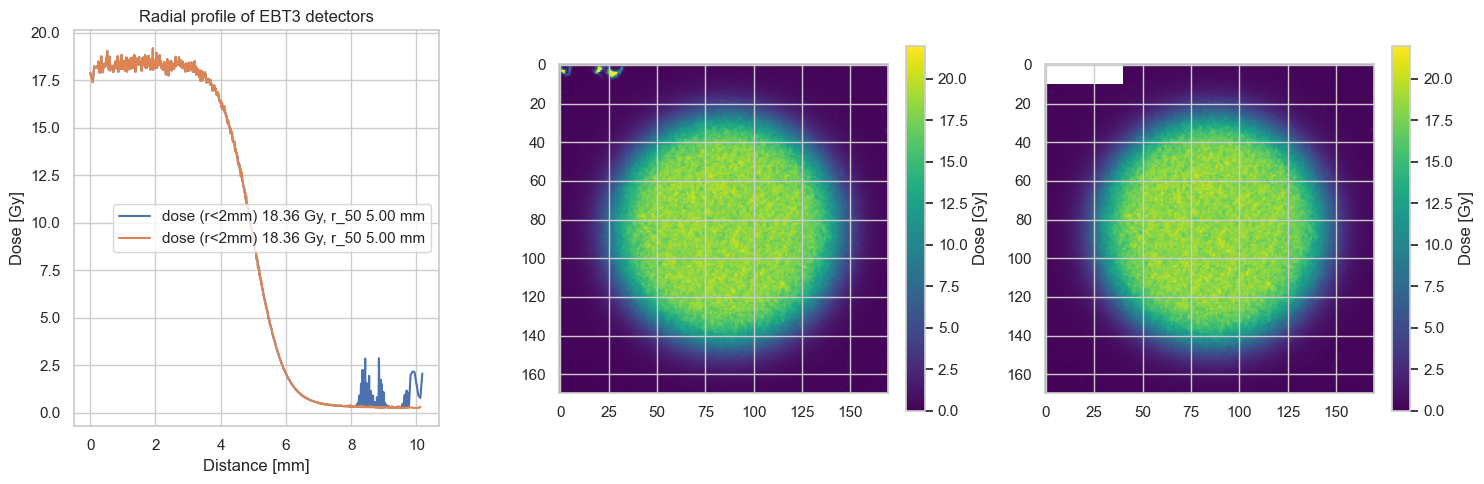

In [21]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=3)

data_cut_cleaned = data_cut.copy()
data_cut_cleaned[ : 10, :40] = np.nan
#data_cut_cleaned[: , -25:] = np.nan
#data_cut_cleaned[250: ,:] = np.nan

data_cut_cleaned[:140 ,200:] = np.nan

df_r = radial_profile(data_cut, ebt_px_to_mm, precision=2).groupby('r_mm_round').mean()
mean_dose = df_r['v'][df_r['r_mm'] < 2].mean()
print(mean_dose)
r_50 = df_r['r_mm'][df_r['v'] < mean_dose/2].min()
df_r.plot(y='v', ax=ax[0], label=f'dose (r<2mm) {mean_dose:.2f} Gy, r_50 {r_50:.2f} mm')

ebt3_df_r_cleaned = radial_profile(data_cut_cleaned, ebt_px_to_mm, precision=2).groupby('r_mm_round').mean(numeric_only=True)
mean_dose_cleaned = ebt3_df_r_cleaned['v'][ebt3_df_r_cleaned['r_mm'] < 2].mean()
print(mean_dose_cleaned)
r_50_cleaned = ebt3_df_r_cleaned['r_mm'][ebt3_df_r_cleaned['v'] < mean_dose_cleaned/2].min()
ebt3_df_r_cleaned.plot(y='v', ax=ax[0], label=f'dose (r<2mm) {mean_dose_cleaned:.2f} Gy, r_50 {r_50_cleaned:.2f} mm')

#ax.set_xlim(0,10)
#ax.set_ylim(0,22)
ax[0].set_xlabel('Distance [mm]')
ax[0].set_ylabel('Dose [Gy]')
ax[0].legend()
ax[0].set_title('Radial profile of EBT3 detectors')

im2 = ax[1].imshow(data_cut, cmap='viridis', vmin=0, vmax=22)
fig.colorbar(im2, ax=ax[1], label='Dose [Gy]', fraction=0.05)

im3 = ax[2].imshow(data_cut_cleaned, cmap='viridis', vmin=0, vmax=22)
fig.colorbar(im3, ax=ax[2], label='Dose [Gy]', fraction=0.05)

fig.set_tight_layout(True)


# OSL MB 20 Gy entrance

In [22]:
base_path

WindowsPath('C:/Users/Legion/OneDrive - ifj.edu.pl/Projects/MB_foils')

In [23]:
proton_path = base_path / '2024-12-12' / '20Gy_wlot'
proton_raw_data = DetectorDataCollection(path=proton_path)
co60_path = base_path / '2024-12-03'
co60_raw_data = DetectorDataCollection(path=co60_path)
co60_path = base_path / '2024-12-03'
co60_raw_data = DetectorDataCollection(path=co60_path)
bg_path = base_path / '2024-10-29' / 'tlo_pusty_det'

19 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

In [24]:
bg_raw_det_path = next(bg_path.glob('**/*tif'))
bg_raw_det_image = DetectorImage(path=bg_raw_det_path, image=read_tiff_img(bg_raw_det_path, border_px=0))
bg_lv_det_path = next(bg_path.with_name(bg_path.name + '_lv').glob('**/*tif'))
bg_lv_det_image = DetectorImage(path=bg_lv_det_path, image=read_tiff_img(bg_lv_det_path, border_px=0))
bg_det_data = DetectorData(raw=bg_raw_det_image, lv=bg_lv_det_image, det_no=-1)

bg_raw_data = DetectorDataCollection(path=bg_path, data={-1: bg_det_data})

In [25]:
proton_det_id = list(proton_raw_data.data.keys())[0]
proton_det_id

19

In [26]:
proton_bg_sub_data = DetectorDataCollection(path=proton_raw_data.path, data=deepcopy(proton_raw_data.data))
for data in proton_bg_sub_data.data.values():
    # out data are save as uint16, dataclasses are frozen
    # its not straightforward to use np.crop(0) or cast to int64
    # therefore we shift data up, perform background subtraction, crop negative values and shift back
    np.add(data.raw.image, bg_det_data.raw.image.max(), out=data.raw.image)    
    np.subtract(data.raw.image, bg_det_data.raw.image, out=data.raw.image)
    np.clip(data.raw.image, a_min=bg_det_data.raw.image.max(), a_max=None, out=data.raw.image)
    np.subtract(data.raw.image, bg_det_data.raw.image.max(), out=data.raw.image)

co60_bg_sub_data = DetectorDataCollection(path=co60_raw_data.path, data=deepcopy(co60_raw_data.data))
for data in co60_bg_sub_data.data.values():

    # out data are save as uint16, dataclasses are frozen
    # its not straightforward to use np.crop(0) or cast to int64
    # therefore we shift data up, perform background subtraction, crop negative values and shift back
    np.add(data.raw.image, bg_det_data.raw.image.max(), out=data.raw.image)    
    np.subtract(data.raw.image, bg_det_data.raw.image, out=data.raw.image)
    np.clip(data.raw.image, a_min=bg_det_data.raw.image.max(), a_max=None, out=data.raw.image)
    np.subtract(data.raw.image, bg_det_data.raw.image.max(), out=data.raw.image)

det_data_dict = {}
for data in proton_bg_sub_data.data.values():
    lv_for_detect = img_for_circle_detection(data.lv.image)
    circle = find_circle_hough_method(lv_for_detect)
    det_data = DetectorData(raw=data.raw, lv=data.lv, det_no=data.det_no, circle=circle)
    det_data_dict[data.det_no] = det_data
    print(f"{data.det_no} ", end='')
proton_det_data = DetectorDataCollection(path=proton_raw_data.path, data=det_data_dict)

det_data_dict = {}
for data in co60_bg_sub_data.data.values():
    lv_for_detect = img_for_circle_detection(data.lv.image)
    circle = find_circle_hough_method(lv_for_detect)
    det_data = DetectorData(raw=data.raw, lv=data.lv, det_no=data.det_no, circle=circle)
    det_data_dict[data.det_no] = det_data
    print(f"{data.det_no} ", end='')
co60_det_data = DetectorDataCollection(path=co60_raw_data.path, data=det_data_dict)

min_radius_protons = min([data.circle.r for data in proton_det_data.data.values()])
min_radius_co60 = min([data.circle.r for data in co60_det_data.data.values()])
min_radius_all = np.floor(min(min_radius_protons, min_radius_co60)).astype(int)

def cut_detector(det_data: DetectorData, min_radius: int, factor: float = 1.2) -> DetectorData:
    lower_x = np.ceil(det_data.circle.x - factor*min_radius).astype(int)
    upper_x = np.floor(det_data.circle.x + factor*min_radius).astype(int)
    lower_y = np.ceil(det_data.circle.y - factor*min_radius).astype(int)
    upper_y = np.floor(det_data.circle.y + factor*min_radius).astype(int)
    
    new_circle = Circle(x=det_data.circle.x - lower_x, y=det_data.circle.y - lower_y, r=det_data.circle.r)
    cut_raw_image = det_data.raw.image[lower_y:upper_y, lower_x:upper_x][:]
    cut_lv_image = det_data.lv.image[lower_y:upper_y, lower_x:upper_x][:]

    return DetectorData(raw=DetectorImage(image=cut_raw_image, path=det_data.raw.path), lv=DetectorImage(image=cut_lv_image, path=det_data.lv.path), det_no=det_data.det_no, circle=new_circle)

det_data_dict = {}
for data in proton_det_data.data.values():
    det_data_dict[data.det_no] = cut_detector(data, min_radius_all)
    print(f"{data.det_no} ", end='')
proton_det_cut_data = DetectorDataCollection(path=proton_det_data.path, data=det_data_dict)

det_data_dict = {}
for data in co60_det_data.data.values():
    det_data_dict[data.det_no] = cut_detector(data, min_radius_all)
    print(f"{data.det_no} ", end='')
co60_det_cut_data = DetectorDataCollection(path=co60_det_data.path, data=det_data_dict)

# px_to_mm = 0.07615501757284933
# r_px = 7 / px_to_mm

19 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 19 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

In [27]:
proton_det_cut_data.data[proton_det_id]

DetectorData(raw=DetectorImage(image=array([[ 0,  0,  0, ..., 14, 18,  0],
       [ 0,  0,  0, ...,  6,  4, 16],
       [38,  0,  0, ...,  2,  0, 25],
       ...,
       [15,  4, 39, ...,  0,  6,  0],
       [15,  0,  0, ...,  0,  0, 21],
       [37,  0,  7, ...,  8, 17,  0]], dtype=uint16), path=WindowsPath('C:/Users/Legion/OneDrive - ifj.edu.pl/Projects/MB_foils/2024-12-12/20Gy_wlot/19/Default/img_channel000_position000_time000000000_z000.tif')), lv=DetectorImage(image=array([[527, 497, 533, ..., 487, 492, 489],
       [496, 497, 521, ..., 501, 525, 475],
       [499, 498, 509, ..., 499, 482, 520],
       ...,
       [467, 502, 503, ..., 506, 509, 500],
       [486, 523, 504, ..., 494, 494, 483],
       [485, 519, 517, ..., 540, 489, 508]], dtype=uint16), path=WindowsPath('C:/Users/Legion/OneDrive - ifj.edu.pl/Projects/MB_foils/2024-12-12/20Gy_wlot/19_lv/Default/img_channel000_position000_time000000000_z000.tif')), det_no=19, circle=Circle(x=154.5, y=154.5, r=131.5))

In [28]:
dose_per_unit_signal_Co60_Gy = 15.378983594121848

In [29]:
proton_uncorrected_dose_Gy = proton_det_cut_data.data[proton_det_id].raw.image / dose_per_unit_signal_Co60_Gy

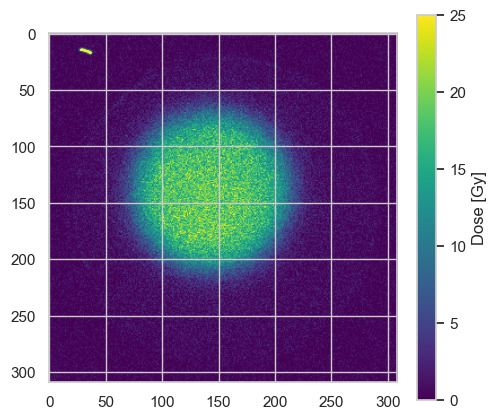

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(proton_uncorrected_dose_Gy, cmap='viridis', vmax=25)
fig.colorbar(im, ax=ax, label='Dose [Gy]', fraction=0.05)


In [31]:
proton_uncorrected_dose_Gy.shape

(309, 309)

r_envelope = 149.10, vmax = 24.03


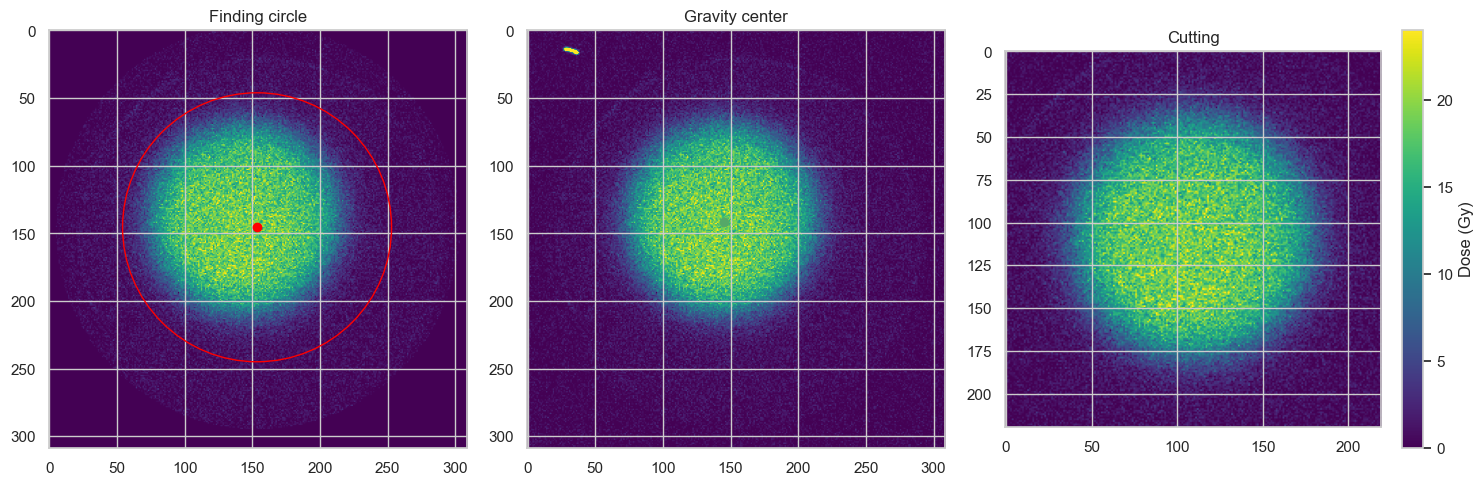

In [32]:
# finding circle
data_for_circle = proton_uncorrected_dose_Gy.copy()
lv_for_detect = img_for_circle_detection(proton_uncorrected_dose_Gy, nsigma=1)
circle = find_circle_hough_method(lv_for_detect, max_radius=100, min_radius=50)
vmin =  0
r_envelope = min(1.5*circle.r, 150)
mask = create_circular_mask(data_for_circle, Circle(x=circle.x, y=circle.y, r=r_envelope))
vmax = 1.1*np.percentile(data_for_circle[mask], 99)
data_for_circle[~mask] = 0
print(f"r_envelope = {r_envelope:.2f}, vmax = {vmax:.2f}")

# finding center of mass
data_for_cm = data_for_circle.copy()
cm = center_of_mass(data_for_cm)

# detector cutting
cut_px = 110
low_y = int(max(0, cm[0] - cut_px))
high_y = int(min(proton_uncorrected_dose_Gy.shape[0], cm[0] + cut_px))
low_x = int(max(0, cm[1] - cut_px))
high_x = int(min(proton_uncorrected_dose_Gy.shape[1], cm[1] + cut_px))
data_cut = proton_uncorrected_dose_Gy[low_y:high_y, low_x:high_x]

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

im1 = axs[0].imshow(data_for_circle, cmap='viridis', vmin=0, vmax=vmax)
axs[0].plot(circle.x, circle.y, 'o', color='red')
axs[0].add_artist(
    plt.Circle(xy=(circle.x, circle.y),
               radius=circle.r,
               color='red',
               fill=False,
               transform=axs[0].transData))
axs[0].set_title('Finding circle')

im2 = axs[1].imshow(proton_uncorrected_dose_Gy, cmap='viridis', vmin=0, vmax=vmax)
axs[1].scatter(cm[1], cm[0], color='g');
axs[1].set_title('Gravity center')

im3 = axs[2].imshow(data_cut, cmap='viridis', vmin=0, vmax=vmax)
axs[2].set_title('Cutting')

fig.colorbar(im3, label='Dose (Gy)', fraction=0.05)

plt.tight_layout()

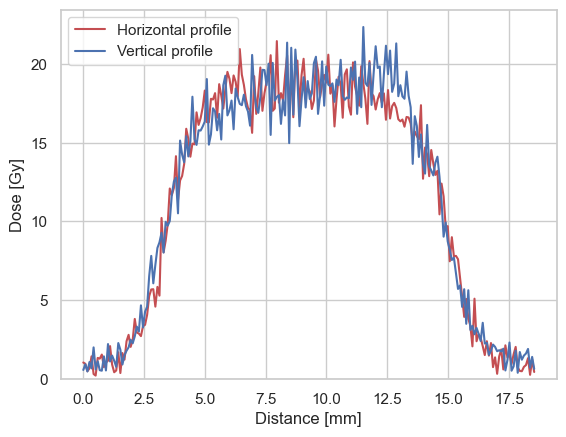

In [33]:
# plot horizontal and vertical profiles
profile_dx = 5
# plot as function of distance in mm, assuming 300dpi
res = 300
y_data = np.mean(data_cut[data_cut.shape[0]//2 - profile_dx//2:data_cut.shape[0]//2 + profile_dx//2,:], axis=0)
y_data_2 = np.mean(data_cut[:, data_cut.shape[1]//2 - profile_dx//2:data_cut.shape[1]//2 + profile_dx//2], axis=1)
x_mm = np.arange(y_data.shape[0]) / res * 25.4
plt.plot(x_mm, y_data , color='r', label='Horizontal profile')
plt.plot(x_mm, y_data_2, color='b', label='Vertical profile')
plt.ylim(0, None)
plt.xlabel('Distance [mm]')
plt.ylabel('Dose [Gy]')
plt.legend();

In [34]:
mb_px_to_mm = 0.07249879204325561

18.6270770439605


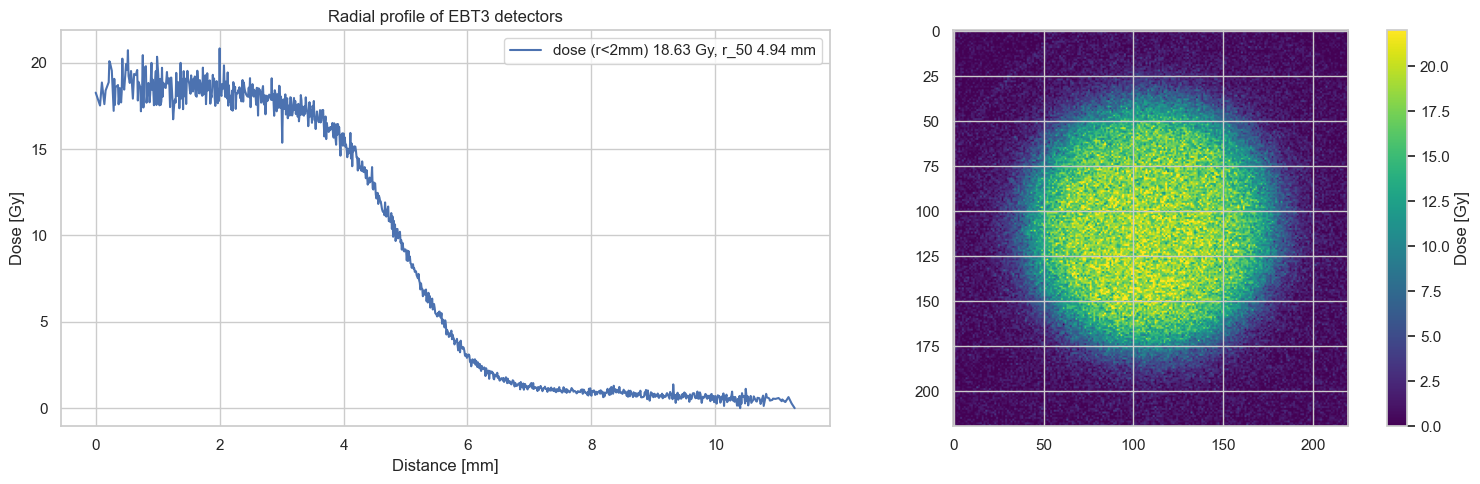

In [35]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)

df_r = radial_profile(data_cut, mb_px_to_mm, precision=2).groupby('r_mm_round').mean()
mean_dose = df_r['v'][df_r['r_mm'] < 2].mean()
print(mean_dose)
r_50 = df_r['r_mm'][df_r['v'] < mean_dose/2].min()
df_r.plot(y='v', ax=ax[0], label=f'dose (r<2mm) {mean_dose:.2f} Gy, r_50 {r_50:.2f} mm')

ax[0].set_xlabel('Distance [mm]')
ax[0].set_ylabel('Dose [Gy]')
ax[0].legend()
ax[0].set_title('Radial profile of EBT3 detectors')

im2 = ax[1].imshow(data_cut, cmap='viridis', vmin=0, vmax=22)
fig.colorbar(im2, ax=ax[1], label='Dose [Gy]', fraction=0.05)

fig.set_tight_layout(True)

In [42]:
#efficiency = 0.92
efficiency = 1

18.6270770439605


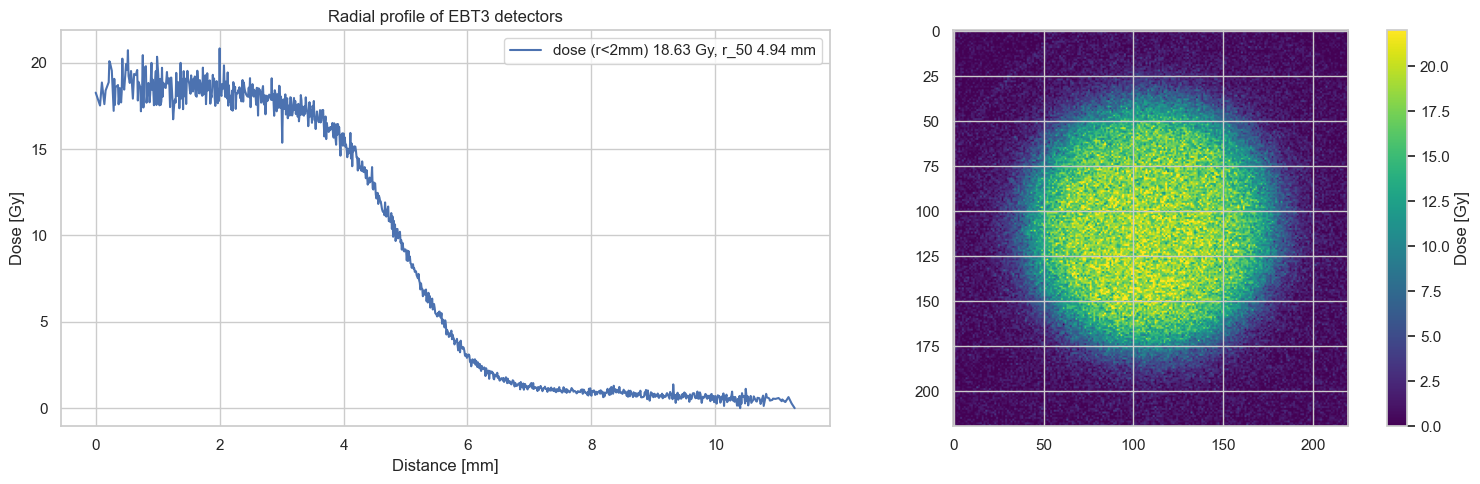

In [58]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)

mb_df_r = radial_profile(data_cut / efficiency, mb_px_to_mm, precision=2).groupby('r_mm_round').mean()
mean_dose = mb_df_r['v'][mb_df_r['r_mm'] < 2].mean()
print(mean_dose)
r_50 = mb_df_r['r_mm'][mb_df_r['v'] < mean_dose/2].min()
mb_df_r.plot(y='v', ax=ax[0], label=f'dose (r<2mm) {mean_dose:.2f} Gy, r_50 {r_50:.2f} mm')

ax[0].set_xlabel('Distance [mm]')
ax[0].set_ylabel('Dose [Gy]')
ax[0].legend()
ax[0].set_title('Radial profile of EBT3 detectors')

im2 = ax[1].imshow(data_cut / efficiency, cmap='viridis', vmin=0, vmax=22)
fig.colorbar(im2, ax=ax[1], label='Dose [Gy]', fraction=0.05)

fig.set_tight_layout(True)

# OSL MB 20 Gy vs EBT3 profile

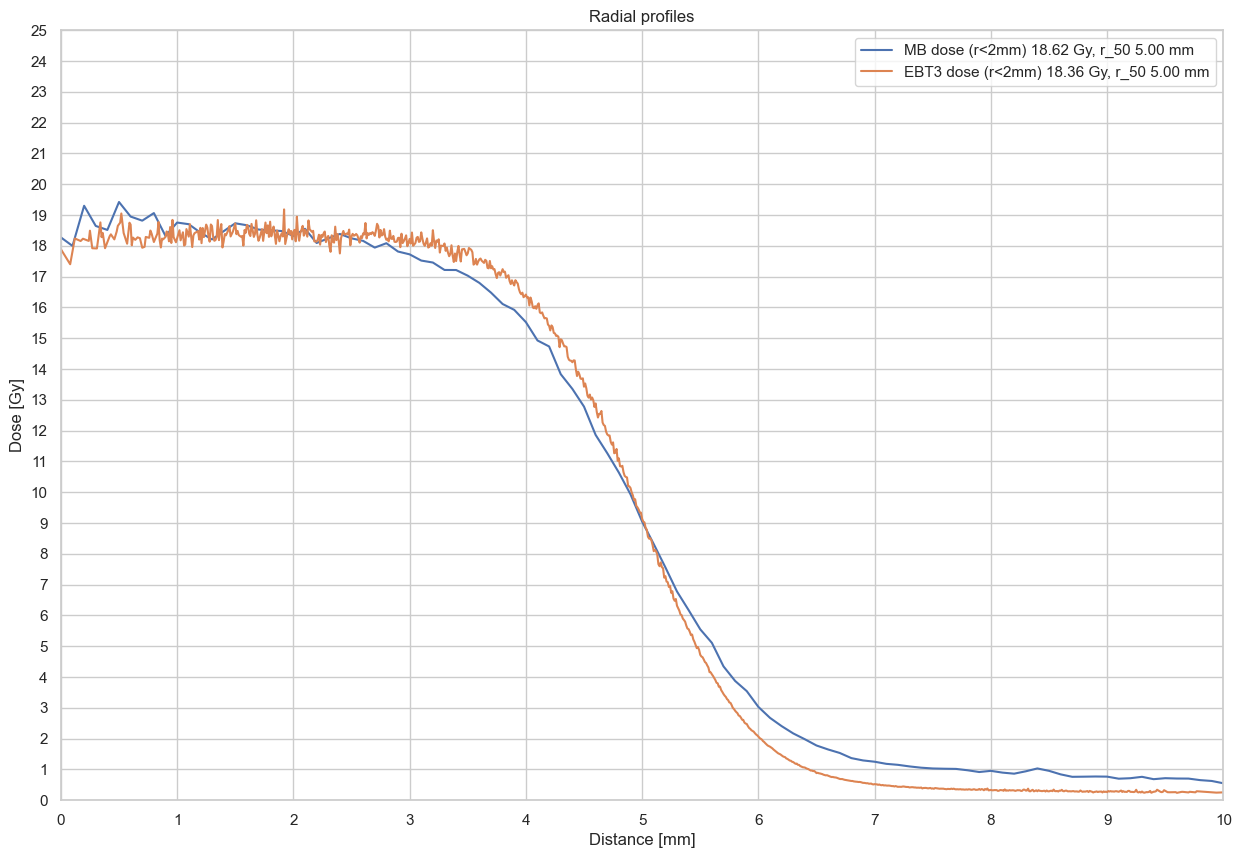

In [57]:
fig, ax = plt.subplots(figsize=(15, 10))

mb_df_r.plot(y='v', ax=ax, label=f'MB dose (r<2mm) {mean_dose:.2f} Gy, r_50 {r_50:.2f} mm')
ebt3_df_r_cleaned.plot(y='v', ax=ax, label=f'EBT3 dose (r<2mm) {mean_dose_cleaned:.2f} Gy, r_50 {r_50_cleaned:.2f} mm')

ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Dose [Gy]')
ax.legend()
ax.set_title('Radial profiles')

ax.set_xlim(0, 10)
ax.set_ylim(0, 25)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

#ax.set_yscale('log')

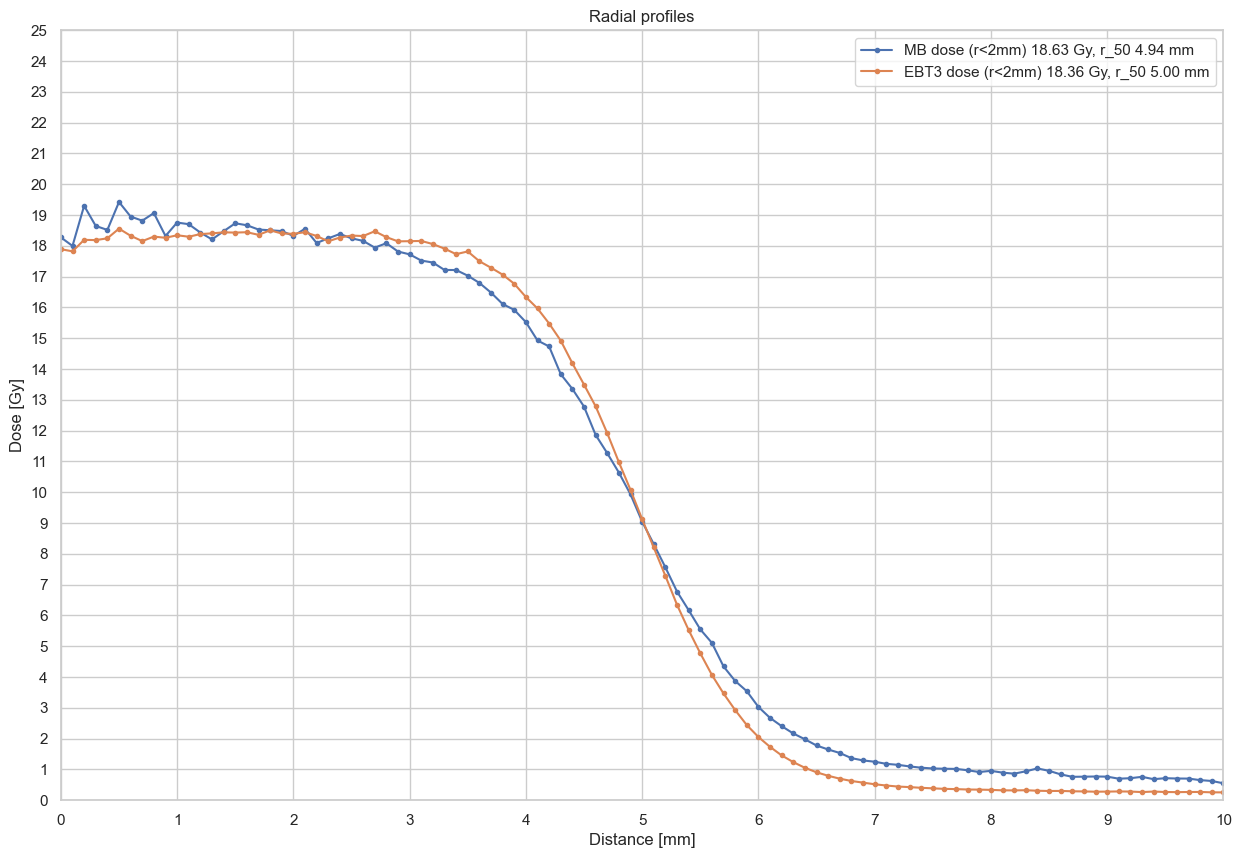

In [61]:
precision = 1
mb_df_r = radial_profile(data_cut / efficiency, mb_px_to_mm, precision=1).groupby('r_mm_round').mean()
ebt3_df_r_cleaned = radial_profile(data_cut_cleaned, ebt_px_to_mm, precision=1).groupby('r_mm_round').mean(numeric_only=True)

fig, ax = plt.subplots(figsize=(15, 10))

mb_df_r.plot(y='v', ax=ax, label=f'MB dose (r<2mm) {mean_dose:.2f} Gy, r_50 {r_50:.2f} mm', marker='.')
ebt3_df_r_cleaned.plot(y='v', ax=ax, label=f'EBT3 dose (r<2mm) {mean_dose_cleaned:.2f} Gy, r_50 {r_50_cleaned:.2f} mm', marker='.')

ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Dose [Gy]')
ax.legend()
ax.set_title('Radial profiles')

ax.set_xlim(0, 10)
ax.set_ylim(0, 25)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))